## Packages

In [2]:
import cv2 as cv
from PIL import Image 
import time
import os

In [52]:
from datetime import datetime

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import joblib

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision
import torch.optim as optim
import torchvision.transforms as T
from torch.autograd import Variable

In [6]:
from facenet_pytorch import InceptionResnetV1

## Loading Prerequisites

In [7]:
# Haar Cascade
face_cascade = cv.CascadeClassifier(r'C:\Users\Anna\Documents\siamese_face_recognition\data\face_detection_default.xml')
eye_cascade = cv.CascadeClassifier(r'C:\Users\Anna\Documents\siamese_face_recognition\data\eye_detection.xml')
smile_cascade = cv.CascadeClassifier(r'C:\Users\Anna\Documents\siamese_face_recognition\data\smile_detection.xml')

In [8]:
# image directories
DIR_CHECK = r'..\photos_cropped'
DIR_CROPPED = r'..\photos_new'

In [9]:
# models
NN_PATH = r'../results/vgg_finetuning'
LOGIT_PATH = '../results/finalized_logistic.sav'

## Plotting Functions

In [10]:
def show_image(img, figsize=(20, 20)):
    """Plottes an image with a given figsize

    Args:
      img: image
      figsize: show image size
    """
    img = np.array(img)
    d = img.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(d)
    plt.show()

## Useful functions

In [11]:
def crop(img, x, y, w, h, increase):
    """crops an image to a certain size

    Args:
      img: image
      x, y, w, h: coordiantes, width, hight
      increase: scale
    """
    w=h=int(min(img.shape[0],img.shape[1] ,int(w*increase),int(h*increase))//increase)
    
    new_x=max(int(x-w*(increase-1)//2),0)
    new_y=max(int(y-h*(increase-1)//2),0)

    new_x=new_x-max(int(new_x+increase*w)-img.shape[1],0)
    new_y=new_y-max(int(new_y+increase*h)-img.shape[0],0)

    x=new_x
    y=new_y

    crop_img = img[y:y+int(h*increase), x:x+int(w*increase)]

    return crop_img

In [12]:
def get_name(DIR):
    """counts the number of images in directory and return a number used as a name of a new image 

    Args:
      DIR: image directory
    """
    d = os.listdir(DIR)
    if len(d) == 0:
        return "0"
    x = [s.split('.')[0] for s in d]
    x.sort()
    return str(int(x[-1]) + 1)

## Model and predictions

In [13]:
# model inception v1
class SiameseFaceRecognition(nn.Module):
    
    def __init__(self):
        super(SiameseFaceRecognition, self).__init__()
        resnet_custom = InceptionResnetV1(pretrained='vggface2').eval()

        num_ftrs = resnet_custom.logits.in_features    
        resnet_custom.logits = nn.Linear(num_ftrs,128)
        
        self.model_custom = resnet_custom
        
         
    def forward_once(self, x):
            
        return self.model_custom(x)
    
    def forward(self, imageA, imageP = None, imageN = None):
        if (imageN is not None) and (imageP is not None):
            resultA = self.forward_once(imageA)
            resultP = self.forward_once(imageP)
            resultN = self.forward_once(imageN)
            return resultA, resultP,resultN
        
        resultA = self.forward_once(imageA)           
        return resultA

In [14]:
#here we apply data aougmantation and scaling for images
transform = T.Compose([
    T.Resize((160, 160)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [15]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cpu")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [16]:
model = SiameseFaceRecognition()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [17]:
checkpoint = torch.load(NN_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_ = checkpoint['epoch']
loss = checkpoint['loss']

In [19]:
logit = joblib.load(LOGIT_PATH)

In [20]:
model.eval()

SiameseFaceRecognition(
  (model_custom): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.

In [21]:
def predict_prob(img_A, DIR_CHECK):
    """returns a probability that an image is from checking directory and tells who that person is

    Args:
      img_A: image of a person to recognize
      DIR_CHECK: checking directory
    """
    
    max_prob = 0
    min_dist = float('inf')
    name = ''
    
    img_A = Image.fromarray(img_A.astype('uint8'), 'RGB')
    
    img_A_trans = torch.reshape(transform(img_A), (1,3, 160, 160))

    show_image(img_A_trans[0], (5, 5))
    vec_A = model(Variable(img_A_trans).to(device))

    for i in os.listdir(DIR_CHECK):

        img = Image.open(os.path.join(DIR_CHECK, i)).convert('RGB')

        img_trans = torch.reshape(transform(img), (1,3, 160, 160))
        
        vec = model(Variable(img_trans).to(device))

        dist = torch.nn.functional.pairwise_distance(vec_A, vec)
        p = logit.predict_proba(dist.detach().numpy().reshape(-1, 1)).flatten()[1]
        if p > max_prob:
            max_prob = p
            name = i
         
    return name.split('.')[0], max_prob

In [67]:
def predict_real_time():
    """performs real time face recognition

    """
    start = datetime.now()
    cap = cv.VideoCapture(0)
    while True:
        # Read the frame
        _, img = cap.read()
        img =cv.flip(img, 1)
        img_rec = img.copy()
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.1, 10)
        eyes = eye_cascade.detectMultiScale(gray, 1.3, 15)
        
        # Draw the rectangle around each face
        
        for (x, y, w, h) in eyes:
            cv.rectangle(img_rec, (x, y), (x+w, y+h), (0, 255, 0), 2)
        for (x, y, w, h) in faces:
            cv.rectangle(img_rec, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Display
        cv.imshow('Capture', img_rec)
        end = datetime.now()
        
        if (len(faces) >= 1) & (len(eyes) == len(faces)*2) & ((end - start).seconds >=5) :
            img_cropped = crop(img, x, y, w, h, 1.5)
            rgb_img = cv.cvtColor(img_cropped, cv.COLOR_BGR2RGB)
            p = predict_prob(rgb_img, DIR_CHECK)
            cv.putText(img=img_cropped, text=f'{p[0]}:{p[1]}', org=(10, 50), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 100, 0),thickness=1)
            cv.imshow('Face', img_cropped) 

            while True:
                if cv.waitKey(1) & 0xFF == ord('x'):
                    cv.destroyAllWindows()
                    cap.release()
                    return 
                
        if cv.waitKey(1) & 0xFF == ord('x'):
            cv.destroyAllWindows()
            break  
    cap.release()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 160, 160)


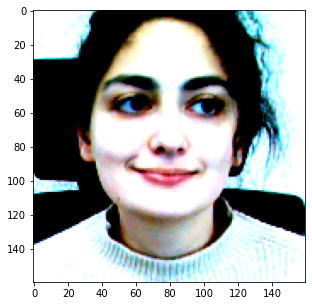

In [68]:
predict_real_time()

In [70]:
# Release the VideoCapture object
cv.destroyAllWindows()

## Adding a new person to the checking set

In [16]:
def dataset_creation(DIR, name):
    """adds image to a directory under a specific name

    Args:
      DIR: directory
      name: name of a person
    """
    cap = cv.VideoCapture(0)
    while True:
        # Read the frame
        _, img = cap.read()
        img =cv.flip(img, 1)
        img_rec = img.copy()
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.1, 10)
        eyes = eye_cascade.detectMultiScale(gray, 1.3, 15)
        
        # Draw the rectangle around each face
        for (x, y, w, h) in faces:
            cv.rectangle(img_rec, (x, y), (x+w, y+h), (255, 0, 0), 2)
        for (x, y, w, h) in eyes:
            cv.rectangle(img_rec, (x, y), (x+w, y+h), (0, 255, 0), 2)
        

        # Display
        cv.imshow('Capture', img_rec)
        while True:
            if len(faces) >= 1:
                if len(eyes) == len(faces)*2:
                    
                    break
                    
        for (x, y, w, h) in faces:
            img_cropped = crop(img, x, y, w, h, 1.6)   
            path = DIR + "\\" + name + ".jpg"
            cv.imwrite(path, img_cropped)
            cv.imshow('Face', img_cropped)  


        # Stop if escape key is pressed            
        if cv.waitKey(1) & 0xFF == ord('x'):
            cv.destroyAllWindows()
            break


    # Release the VideoCapture object
    cap.release() 

In [ ]:
dataset_creation(DIR_CHECK, 'Anna')